In [54]:
%matplotlib inline

from collections import namedtuple
from contextlib import contextmanager
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
from pypika import functions as fn
from pypika import MySQLQuery as Query, Table
from pypika.terms import CustomFunction, Function, Term
import re

figsize(12.5, 4)

In [55]:
@contextmanager
def managed_cnx():
        cnx = mysql.connector.connect(
            user='root', password='root',
            database='twitter', charset='utf8mb4')
        try:
            yield cnx
        finally:
            cnx.close()

@contextmanager
def managed_cursor(**kwargs):
    with managed_cnx() as cnx:
        cursor = cnx.cursor(**kwargs)
        try:
            yield cursor
        finally:
            cursor.close()

In [56]:
with managed_cursor() as cursor:
    cursor.execute(str(Query.from_('tweets').select(fn.Count('*'))))
    print(cursor.fetchone())

(249785,)


In [57]:
UnixTimestamp = CustomFunction('unix_timestamp', ['date'])
FromUnixtime = CustomFunction('from_unixtime', ['unixtime'])

In [58]:
tweets, users = Table('tweets'), Table('users')

In [61]:
KeywordTrajectory = namedtuple('KeywordTrajectory', ['created_at', 'count'])

def keyword_trajectory(cursor, truncated_by='10 minutes'):
    minutes = re.sub(r'^(\d+)\s+minutes$', r'\1', truncated_by)
    assert(minutes.isdecimal())
    seconds = 60 * int(minutes)
    alias = 'truncated_by_{}min'.format(minutes)
    
    # TODO: keyword による絞り込み

    s = Query.from_(tweets) \
    .select(
       FromUnixtime(fn.Floor(
            UnixTimestamp(tweets.created_at) / seconds) * seconds,
                   alias=alias),
        fn.Count(tweets.id)) \
    .groupby(alias)
    
    print('SQL: {}'.format(s))
    cursor.execute(str(s))

    return [KeywordTrajectory._make(r) for r in cursor]

In [62]:
with managed_cursor(buffered=True) as cursor:
    df = pd.DataFrame(data=keyword_trajectory(cursor, truncated_by='30 minutes'))
    df = df.set_index('created_at')
    print(df.head())

SQL: SELECT from_unixtime(FLOOR(unix_timestamp(`created_at`)/1800)*1800) `truncated_by_30min`,COUNT(`id`) FROM `tweets` GROUP BY `truncated_by_30min`
                     count
created_at                
2020-03-30 03:30:00   1615
2020-03-30 04:00:00   6471
2020-03-30 04:30:00   5829
2020-03-30 05:00:00   4938
2020-03-30 05:30:00   5549


「緊急事態宣言」と「ロックダウン」のツイート数の時系列推移

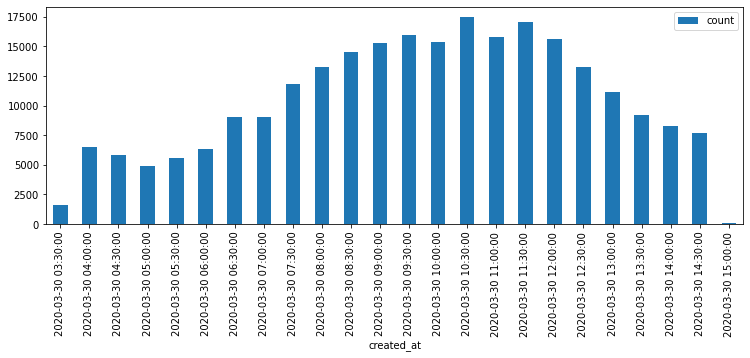

In [63]:
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)

A Field Guide to "Fake News"より、

```
While online and platform metrics often serve to take measure of engagement by
means of what Theodore Porter calls “thin descriptions”[11] – i.e. aggregated
quantities such as total likes, shares, posts – we suggest different ways of
exploring how different publics engage with and ascribe meaning to fake news and
how this moves and mobilises different actors in the process.
```

試しに、retweet 数で足切りした上で、時系列にその tweet を並べてみたい。
まず、retweet 数の分布をしりたい

In [64]:
Tweet = namedtuple('Tweet', ['id', 'retweet_count', 'created_at', 'url', 'screen_name'])

def list_tweets(cursor):
    s = Query.from_(tweets) \
    .join(users) \
    .on(tweets.tweeted_by == users.id) \
    .select(
        tweets.id,
        tweets.retweet_count,
        tweets.created_at,
        fn.Concat('https://twitter.com/', users.screen_name, '/status/', tweets.id).as_('url'),
        users.screen_name,
    ) \
    .where(Term.isnull(tweets.retweeted_status))

    print('SQL: {}'.format(s))
    cursor.execute(str(s))
    
    return [Tweet._make(r) for r in cursor]

In [65]:
with managed_cursor(buffered=True) as cursor:
    data = list_tweets(cursor)
    df = pd.DataFrame(data=data)
    df = df.set_index('created_at')
    df.head()

SQL: SELECT `tweets`.`id`,`tweets`.`retweet_count`,`tweets`.`created_at`,CONCAT('https://twitter.com/',`users`.`screen_name`,'/status/',`tweets`.`id`) `url`,`users`.`screen_name` FROM `tweets` JOIN `users` ON `tweets`.`tweeted_by`=`users`.`id` WHERE `tweets`.`retweeted_status` IS NULL


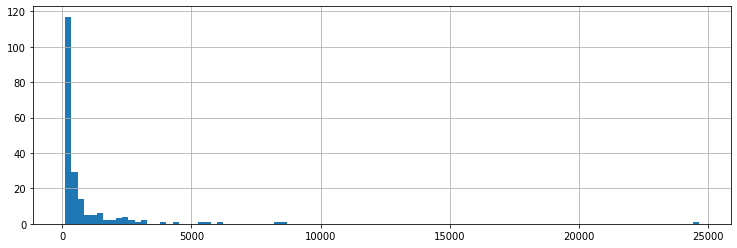

In [66]:
fig, ax = plt.subplots()
df[(100 < df['retweet_count'])]['retweet_count'].hist(ax=ax, bins=100)

In [67]:
df.count()

id               71056
retweet_count    71056
url              71056
screen_name      71056
dtype: int64

In [68]:
df[df['retweet_count'] > 1_000].count()

id               37
retweet_count    37
url              37
screen_name      37
dtype: int64

In [69]:
df[df['retweet_count'] > 1_000]

,id,retweet_count,url,screen_name
created_at,,,,
2020-03-30 12:29:45,1244602713708433415,1222,https://twitter.com/akomugi/status/12446027137...,akomugi
2020-03-30 12:00:13,1244595282920251392,2330,https://twitter.com/BFJNews/status/12445952829...,BFJNews
2020-03-30 08:50:46,1244547606463647744,1495,https://twitter.com/daitojimari/status/1244547...,daitojimari
2020-03-30 08:15:53,1244538827961589760,3201,https://twitter.com/FNN_News/status/1244538827...,FNN_News
2020-03-30 13:58:00,1244624921730232320,1886,https://twitter.com/goando/status/124462492173...,goando
2020-03-30 13:25:38,1244616779923484672,1304,https://twitter.com/HAKOCONNEMAN/status/124461...,HAKOCONNEMAN
2020-03-30 07:27:39,1244526687494135808,8336,https://twitter.com/hiroyoshimura/status/12445...,hiroyoshimura
2020-03-30 06:05:42,1244506065791782913,6078,https://twitter.com/HuffPostJapan/status/12445...,HuffPostJapan
2020-03-30 11:43:10,1244590990490361858,1293,https://twitter.com/ikorin/status/124459099049...,ikorin


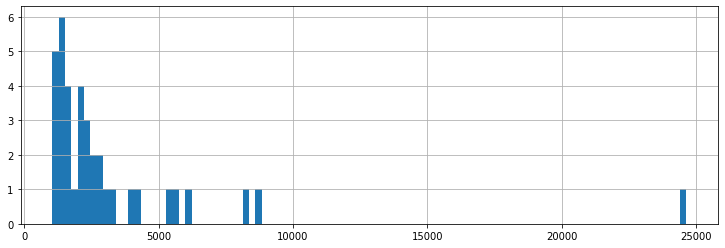

In [70]:
fig, ax = plt.subplots()
df[df['retweet_count'] > 1_000]['retweet_count'].hist(ax=ax, bins=100)

In [71]:
import hashlib

def naive_hash(text):
    return hashlib.sha1(text.encode('utf-8')).hexdigest()

df_gt_1_000_retweets = df[df['retweet_count'] > 1_000]
df_gt_1_000_retweets.drop('id', axis=1, inplace=True)
df_gt_1_000_retweets.loc[:, 'screen_name'] = \
    df_gt_1_000_retweets.loc[:, 'screen_name'].map(naive_hash)

/home/p-baleine/.local/share/virtualenvs/fabrication_of_state_of_emergency_20200330-PMno-HTX/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/p-baleine/.local/share/virtualenvs/fabrication_of_state_of_emergency_20200330-PMno-HTX/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [72]:
df_gt_1_000_retweets

,retweet_count,url,screen_name
created_at,,,
2020-03-30 12:29:45,1222,https://twitter.com/akomugi/status/12446027137...,c9520489f0a47b96cc61c75434e9891c41224cff
2020-03-30 12:00:13,2330,https://twitter.com/BFJNews/status/12445952829...,debb15ff11270a075d2ce4f27c001d19cb8a5ebd
2020-03-30 08:50:46,1495,https://twitter.com/daitojimari/status/1244547...,40827439839d640a7868be4b64732ef0f7b6d10f
2020-03-30 08:15:53,3201,https://twitter.com/FNN_News/status/1244538827...,c633e20b505e291d89833201f797c2a1360c8816
2020-03-30 13:58:00,1886,https://twitter.com/goando/status/124462492173...,00c393bf665d34b69d210a5e394c120debf86ca5
2020-03-30 13:25:38,1304,https://twitter.com/HAKOCONNEMAN/status/124461...,8fbe526277b3b9afaa385745dd4dbec18c2b7b35
2020-03-30 07:27:39,8336,https://twitter.com/hiroyoshimura/status/12445...,e07740d3389e6a017a10b8fd8a0a226e77c2bd8a
2020-03-30 06:05:42,6078,https://twitter.com/HuffPostJapan/status/12445...,5819f57795c443a47332aa72f2c8ec138df7c96e
2020-03-30 11:43:10,1293,https://twitter.com/ikorin/status/124459099049...,67d7f7043e282351a863bf4d4dfcf1fbdd279d4d


In [73]:
df_gt_1_000_retweets.to_csv('data/over_1_000_retweets.csv')